# Test Gemini vs Ensemble for MMLU


to do:

-ignore claude, add gemma, palm

In [1]:
import os
import copy
import json
import random
import pandas as pd
from pprint import pprint
from datetime import datetime
from datasets import load_dataset

from utils import Annotate
from config import PALM_CONFIG, GEMINI_CONFIG, CLAUDE_CONFIG

In [2]:
seed = 420
now = datetime.now().strftime("%Y%m%d")

In [3]:
dataset = load_dataset("cais/mmlu", "all")
n_sample = 50
# # take a small sample for dev purposes
dataset = dataset['test'].shuffle(seed=seed).select(range(n_sample))

# # user provided data description
# DESCRIPTION = """
# This is a massive multitask test consisting of multiple-choice questions from various branches of knowledge.
# The test spans subjects in the humanities, social sciences, hard sciences, and other areas that are important for some people to learn.
# To attain high accuracy on this test, models must possess extensive world knowledge and problem solving ability.
# This covers 57 subjects  across STEM, the humanities, the social sciences, and more. 
# It ranges in difficulty from an elementary level to an advanced professional level, and it tests both world knowledge and problem solving ability. 
# Subjects range from traditional areas, such as mathematics and history, to more specialized areas like law and ethics.
# """


In [4]:
gemini_prompt_template = """
<QUESTION>
{datapoint}
</QUESTION>
------------

<CHOICES>
{labels}
</choices>
------------

INSTRUCTION:
- read the above question carefully.
- you are given 4 choices seperated by comma in <CHOICES>.
- take your time and pick the precise correct answer from <CHOICES> for the given <QUESTION>.
- remember that there is always only one correct answer.
- return the exact correct answer from <CHOICES>. Don't provide explanations.
"""

In [5]:
prompt = [gemini_prompt_template.format(datapoint=x['question'],
                                        labels=x['choices']) for x in dataset]
print(len(prompt))

50


In [6]:
models = [
    "gemini",
    "palm",
    # "claude"
    ]

PALM_CONFIG["project_config"]["qpm"] = 150

palm_1 =  copy.deepcopy(PALM_CONFIG)
palm_1['config_name'] = "temp_0.4"

palm_2 =  copy.deepcopy(PALM_CONFIG)
palm_2['config_name'] = "temp_0.9"
palm_2["generation_config"]['temperature'] = 0.9

GEMINI_CONFIG["project_config"]["qpm"] = 100

gemini_1 =  copy.deepcopy(GEMINI_CONFIG)
gemini_1['config_name'] = "-1.0-pro-001"

gemini_2 =  copy.deepcopy(GEMINI_CONFIG)
gemini_2['config_name'] = "-1.5-flash-001"
gemini_2['"model"'] = "gemini-1.5-flash-001"

gemini_3 =  copy.deepcopy(GEMINI_CONFIG)
gemini_3['config_name'] = "-1.0-ultra-001"
gemini_3['"model"'] = "gemini-1.0-ultra-001"



model_config = {
    "gemini": [
        gemini_1,
        gemini_2,
        gemini_3
         ],
    "palm": [
        palm_1, 
        palm_2
        ],
    # "claude": [
    #     CLAUDE_CONFIG
    # ]
}

ann = Annotate()


In [7]:
output_dict = await ann.classification(prompt, models, model_config)

Gathering palm_temp_0.9 results: 100%|██████████| 50/50 [00:00<00:00, 125577.96it/s]


In [8]:
llm_response = {}

for k in output_dict.keys():
    llm_response[k] = []
    for idx, r in enumerate(output_dict[k]):
        if r is not None:
            stripped_r = r.strip().strip("'")
            if stripped_r in dataset['choices'][idx]:
                llm_response[k].append(dataset['choices'][idx].index(stripped_r))
            else:
                # Handle case where stripped_r is not found in choices
                llm_response[k].append(None)
        else:
            # Handle None values appropriately
            llm_response[k].append(None)

In [9]:
llm_response

{'gemini_-1.0-pro-001': [None,
  1,
  None,
  None,
  2,
  1,
  1,
  2,
  3,
  2,
  1,
  2,
  0,
  2,
  0,
  1,
  None,
  1,
  2,
  1,
  3,
  2,
  1,
  2,
  3,
  1,
  1,
  None,
  2,
  1,
  3,
  2,
  1,
  2,
  1,
  1,
  0,
  1,
  2,
  0,
  3,
  None,
  1,
  2,
  None,
  None,
  3,
  1,
  3,
  3],
 'gemini_-1.5-flash-001': [None,
  0,
  None,
  None,
  2,
  1,
  1,
  2,
  0,
  2,
  1,
  2,
  0,
  2,
  0,
  1,
  None,
  1,
  2,
  1,
  3,
  2,
  3,
  2,
  2,
  1,
  1,
  None,
  2,
  1,
  3,
  2,
  1,
  1,
  1,
  1,
  0,
  3,
  2,
  0,
  3,
  2,
  0,
  2,
  None,
  None,
  3,
  1,
  3,
  3],
 'gemini_-1.0-ultra-001': [None,
  0,
  None,
  None,
  2,
  1,
  1,
  2,
  3,
  0,
  1,
  2,
  0,
  2,
  1,
  1,
  0,
  1,
  2,
  1,
  3,
  2,
  2,
  2,
  0,
  1,
  1,
  None,
  2,
  1,
  3,
  2,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  3,
  2,
  1,
  2,
  None,
  1,
  None,
  0,
  3,
  3],
 'palm_temp_0.4': [2,
  0,
  1,
  3,
  2,
  2,
  1,
  2,
  2,
  0,
  2,
  2,
  None,
  2,
  0,
  1,
  0,
  1,
 

In [10]:
# with open(f"./data/{now}/llm_response_{n_sample}__{now}.json", "r") as f:
#     llm_response= json.load(f)

In [11]:
def drop_nones(data):
    df = pd.DataFrame.from_dict(llm_response).dropna().astype(int)
    print(df.shape)
    data = df.to_dict(orient="list")

    return data, df.index.to_list()

def convert_dict_to_indexed_list(data_dict):
    number_map = {key: index for index, key in enumerate(data_dict.keys())}
    max_len = len(next(iter(data_dict.values())))

    result = []
    for index in range(max_len):
        for key, value_list in data_dict.items():
            value = value_list[index]
            converted_value = value 
            result.append([index, number_map[key], converted_value])
    return result
    

def generate_task_config(response_dict, num_classes):

    num_labels = sum(len(lst) for lst in response_dict.values())
    num_tasks =  len(list(response_dict.values())[0])
    num_labelers = len(response_dict)
    z  = 1/num_classes


    tc = [num_labels, num_labelers, num_tasks, num_classes]
    tc.extend([z] * tc[-1])

    return tc

In [12]:
n_class = 4
llm_response, keep_idx = drop_nones(llm_response)
task_conf = generate_task_config(llm_response, n_class)
llm_result_list = convert_dict_to_indexed_list(llm_response)
llm_result_list.insert(0, task_conf)

(39, 5)


In [13]:
keep_idx

[1,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 42,
 43,
 47,
 48,
 49]

In [14]:
gt_dict = {"gt": dataset["answer"]}
gt_dict["gt"] = [x for i, x in enumerate(gt_dict["gt"]) if i in keep_idx]

gt_dict["question"] = [q for i,q in enumerate(dataset['question']) if i in keep_idx]

len(gt_dict["gt"])

39

In [15]:
try:
    os.mkdir(f"./data/{now}")
except:
    pass

with open(f"./data/{now}/llm_response_{n_sample}__{now}.json", "w") as json_file:
    json.dump(llm_response, json_file)

pd.DataFrame(gt_dict).to_csv(f"./data/{now}/gt_{n_sample}__{now}.csv", index=False)

In [16]:
filename = f"./data/{now}/llm_response_{n_sample}__{now}.txt"

with open(filename, "w") as file:
    for sublist in llm_result_list:
        line = " ".join(str(num) for num in sublist)  # Convert to string, join with spaces
        file.write(line + "\n")  # Write line and add newline
filename

'./data/20240530/llm_response_50__20240530.txt'

#  GLAD

In [17]:
from utils import glad

In [18]:
glad_output = glad(filename)

In [19]:
glad_output = glad(filename)
glad_output

{'alpha': {0: 0.7554699478616163,
  1: 0.7381433730304823,
  2: 0.8334161418318888,
  3: 1.5139108516121806,
  4: 1.162811617984595},
 'beta': {0: 1.9719616389488468,
  1: 0.9091598191195672,
  2: 4.1487995059356315,
  3: 4.1487995059356315,
  4: 0.8703399675666524,
  5: 1.3226648405224026,
  6: 0.9091598191195672,
  7: 4.1487995059356315,
  8: 4.1487995059356315,
  9: 1.881174058837864,
  10: 4.1487995059356315,
  11: 4.1487995059356315,
  12: 4.1487995059356315,
  13: 4.1487995059356315,
  14: 4.1487995059356315,
  15: 4.1487995059356315,
  16: 1.2950626218383634,
  17: 4.1487995059356315,
  18: 1.2849976092135704,
  19: 4.1487995059356315,
  20: 4.1487995059356315,
  21: 4.1487995059356315,
  22: 4.1487995059356315,
  23: 4.1487995059356315,
  24: 4.1487995059356315,
  25: 1.3226648405224026,
  26: 1.0957418282351776,
  27: 4.1487995059356315,
  28: 4.1487995059356315,
  29: 4.148799505935632,
  30: 1.127923795081271,
  31: 1.3226648405224026,
  32: 4.148799505935632,
  33: 4.148799

# Eval

In [ ]:
import json
import pandas as pd
from collections import Counter
from typing import Dict, List
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
def get_majority_vote(label_dict: Dict[str, List[int]]) -> List[int]:
    """
    Finds the majority value for each element across multiple lists within a dictionary.

    Args:
        label_dict: A dictionary where keys are identifiers and values are lists of labels.

    Returns:
        A list of majority values corresponding to each element position.
    """
    list_of_labels = list(label_dict.values())  # Extract values into a list
    majority_values = []

    for elements in zip(*list_of_labels):
        element_counts = Counter(elements)
        most_common_element = element_counts.most_common(1)[0]
        majority_values.append(most_common_element[0])

    return majority_values


def accuracy_with_none_penalty(y_true, y_pred):
    filtered_y_true = []
    filtered_y_pred = []

    for true, pred in zip(y_true, y_pred):
        if pred is not None:  # Only include non-None predictions
            filtered_y_true.append(true)
            filtered_y_pred.append(pred)
        else:
            filtered_y_true.append(true)  # Include true label
            filtered_y_pred.append(-1)   # Replace None with wrong label (e.g., -1)

    return accuracy_score(filtered_y_true, filtered_y_pred)

In [ ]:
# with open("./data/raw_llm_response_100__20240529.json", "r") as f:
#     llm_response = json.load(f)

# df_glad = pd.read_csv("./data/label_glad__20240529.csv")


In [ ]:
llm_response["majority"] = get_majority_vote(llm_response)
# llm_response["glad"] = df_glad["label"].values
llm_response["glad"] = list(glad_output['labels'].values())

In [ ]:
d = {}
for k, v in llm_response.items():
    d[k] = accuracy_with_none_penalty(dataset['answer'], v) * 100

In [ ]:
df = pd.DataFrame([d]).T.reset_index()
df.columns = ["model", "accuracy"]

In [ ]:
pd.DataFrame()

In [ ]:
glad_output.keys()

In [ ]:
# hard questions
q_list = [q for i,q in enumerate(dataset['question']) if i in keep_idx]
glad_output["beta"]
question_d = {"question": q_list,
              "task difficulty": list(glad_output["beta"].values()),
              "label confidence": list(glad_output["probZ"].values())
}

In [ ]:
pd.DataFrame.from_dict(question_d)


In [21]:
llm_response.values()

dict_values([[1, 1, 1, 2, 3, 2, 1, 2, 2, 0, 1, 1, 2, 1, 3, 2, 1, 2, 3, 1, 1, 2, 1, 3, 2, 1, 2, 1, 1, 0, 1, 2, 0, 3, 1, 2, 1, 3, 3], [0, 1, 1, 2, 0, 2, 1, 2, 2, 0, 1, 1, 2, 1, 3, 2, 3, 2, 2, 1, 1, 2, 1, 3, 2, 1, 1, 1, 1, 0, 3, 2, 0, 3, 0, 2, 1, 3, 3], [0, 1, 1, 2, 3, 0, 1, 2, 2, 1, 1, 1, 2, 1, 3, 2, 2, 2, 0, 1, 1, 2, 1, 3, 2, 0, 1, 1, 1, 0, 1, 1, 0, 3, 1, 2, 0, 3, 3], [0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 1, 3, 2, 1, 2, 2, 1, 1, 2, 1, 3, 2, 0, 1, 1, 1, 0, 1, 1, 0, 3, 1, 2, 1, 3, 3], [0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 1, 3, 2, 1, 2, 2, 1, 1, 2, 1, 3, 2, 0, 2, 1, 1, 0, 2, 1, 0, 3, 1, 2, 1, 3, 3]])

In [23]:
import pandas as pd
from itertools import combinations

def calculate_agreement_matrix(data_dict):
    """Calculates agreement between lists in a dictionary for matching indices.

    Args:
        data_dict: A dictionary where keys are labels and values are lists of equal length.

    Returns:
        A Pandas DataFrame representing the agreement matrix.
    """

    df = pd.DataFrame(data_dict)
    keys = df.columns

    agreement_matrix = pd.DataFrame(index=keys, columns=keys)

    for key1, key2 in combinations(keys, 2):  # Iterate over all key pairs
        matches = (df[key1] == df[key2]).sum()  # Count matching values
        total = len(df)  # Total number of values
        agreement_matrix.loc[key1, key2] = agreement_matrix.loc[key2, key1] = matches / total

    return agreement_matrix

# Example Usage:
data = {'list1': [1, 1, 0, 2, 1],
        'list2': [1, 0, 0, 2, 1],
        'list3': [1, 1, 1, 0, 1]}

agreement_matrix = calculate_agreement_matrix(data)
print(agreement_matrix.to_markdown(numalign="left", stralign="left"))


|       | list1   | list2   | list3   |
|:------|:--------|:--------|:--------|
| list1 | nan     | 0.8     | 0.6     |
| list2 | 0.8     | nan     | 0.4     |
| list3 | 0.6     | 0.4     | nan     |


In [29]:
dm = calculate_agreement_matrix(llm_response)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_3819116/1688410825.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(dm.fillna(0), annot=True, linewidth=.5, cmap=sns.cubehelix_palette(as_cmap=True))


<Axes: >

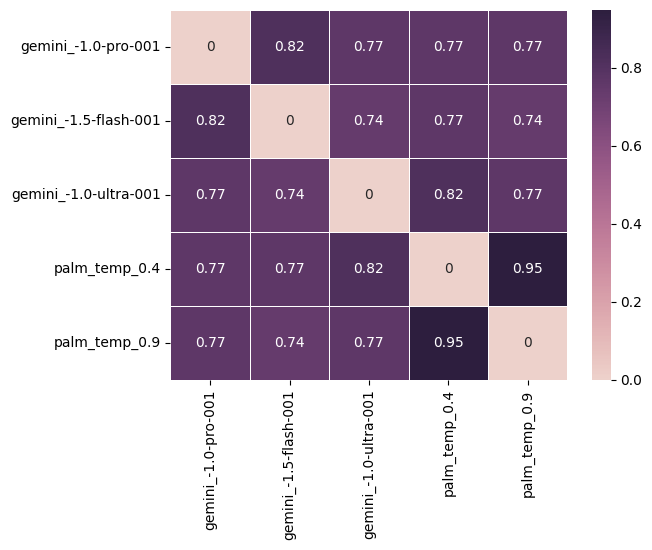

/tmp/ipykernel_3819116/3875855799.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dm.fillna(0)


,gemini_-1.0-pro-001,gemini_-1.5-flash-001,gemini_-1.0-ultra-001,palm_temp_0.4,palm_temp_0.9
gemini_-1.0-pro-001,0.000000,0.820513,0.769231,0.769231,0.769231
gemini_-1.5-flash-001,0.820513,0.000000,0.743590,0.769231,0.743590
gemini_-1.0-ultra-001,0.769231,0.743590,0.000000,0.820513,0.769231
palm_temp_0.4,0.769231,0.769231,0.820513,0.000000,0.948718
palm_temp_0.9,0.769231,0.743590,0.769231,0.948718,0.000000
